<a href="https://colab.research.google.com/github/LEFT-BEE/KMU-Algorithm/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99/recomendedsystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 영화 추천 시스템

## Task 1. 데이터 준비하기

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile as zipfile
import torch
import torch.nn.functional as F
import math
import random

In [ ]:
r = requests.get("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
open("movielens.zip" , "wb").write(r.content)
zipfile.ZipFile("movielens.zip").extractall()

In [ ]:
def str_to_set(x):
  genre_set = set()
  for item in eval(x):
    genre_set.add(item['name'])
  return genre_set

In [ ]:
#Task 1-1
rating_data = pd.read_csv("./ml-latest-small/ratings.csv")
#데이터를 계속 섞어준다
rating_data.movieId = pd.to_numeric(rating_data.movieId)
rating_data.rating = pd.to_numeric(rating_data.rating)
train_len = int(len(rating_data) * 0.8)
train_data  = rating_data[:train_len]
test_data = rating_data[train_len:]

In [ ]:
#Task 1-2
movies = pd.read_csv("./ml-latest-small/movies.csv")
movies.genres = movies.genres.apply(lambda x : x.split("|"))
movies.genres = movies.genres.apply(set)
movies.movieId = pd.to_numeric(movies.movieId)
#영화 사전 만들기
movie_dic = dict()
for ld , title in zip(movies.movieId , movies.title):
  movie_dic[ld] = title
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"{Children, Animation, Comedy, Fantasy, Adventure}"
1,2,Jumanji (1995),"{Fantasy, Adventure, Children}"
2,3,Grumpier Old Men (1995),"{Comedy, Romance}"
3,4,Waiting to Exhale (1995),"{Comedy, Romance, Drama}"
4,5,Father of the Bride Part II (1995),{Comedy}


In [ ]:
#Task 1-3
tags = pd.read_csv("./ml-latest-small/tags.csv")
tags.movieId = pd.to_numeric(tags.movieId)
mov = sorted(list(set(tags.movieId)))
data = []
for ld in mov:
  data.append(set(map(lambda x : x.lower(), tags[tags['movieId'] == ld].tag)))

movie_tag = pd.DataFrame(list(zip(mov , data)) ,  columns=['movieId' , 'tag'])
movie_tag.head()

,movieId,tag
0,1,"{fun, pixar}"
1,2,"{fantasy, magic board game, game, robin williams}"
2,3,"{old, moldy}"
3,5,"{remake, pregnancy}"
4,7,{remake}


## Task 2. Latent Factor 모델을 이용하여 학습하기

In [ ]:
#Task 2-1 p,q등 파라미터 초기화후 optimizer등을 이용하여 학습하기
test_data = test_data.sample(frac = 1).reset_index(drop =True)
train_data = train_data.sample(frac = 1).reset_index(drop=True)

items = torch.LongTensor(train_data.movieId)
users = torch.LongTensor(train_data.userId)
ratings = torch.FloatTensor(train_data.rating)
test_items = torch.LongTensor(test_data.movieId)
test_users = torch.LongTensor(test_data.userId)
test_ratings = torch.FloatTensor(test_data.rating)

In [ ]:
LR = 0.01
EPOCHS = 700
lambda_p = 0.001
lambda_q = 0.001
lambda_bias = 0.001
rank = 10
numItems = rating_data.movieId.max() + 1
numUsers = rating_data.userId.max() + 1

P = torch.randn(numItems, rank, requires_grad=True) 
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_item = torch.zeros(numItems, requires_grad=True)
bias_user = torch.zeros(numUsers, requires_grad=True)
mean =  (ratings.sum() / len(ratings)).item()

In [ ]:
X = []
Y = []
Y_test = []
optimizer = torch.optim.Adam([P,Q ,bias_item , bias_user] , lr = LR)

for epoch in range(EPOCHS):
  predict = torch.sum(P[items] * Q[users] , dim = 1) + bias_item[items] + bias_user[users] + mean
  criterion = F.mse_loss(predict , ratings)
  cost = criterion + lambda_p * torch.sum(P**2) +lambda_q * torch.sum(Q**2) + lambda_bias * torch.sum(bias_item**2) + lambda_bias * torch.sum(bias_user**2)
  train_rmse = torch.sqrt(criterion)

  with torch.no_grad():  
    X.append(epoch)
    Y.append(train_rmse)

    predict_test = torch.sum(P[test_items] * Q[test_users], dim=1) + mean + bias_item[test_items] + bias_user[test_users]
    test_rmse = torch.sqrt(F.mse_loss(predict_test , test_ratings))
    Y_test.append(test_rmse)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print("epoch: {}, train_cost: {:.6f} , train_rmse: {:.6f} , test_rmse: {:.6f} " .format(epoch, cost.item() ,train_rmse, test_rmse))

  #처음에는 learning rate를 크게해주다가 점점 작게해준다.
  if epoch% 50 == 0:
    LR = (1+ math.cos((epoch*math.pi) / EPOCHS)) * 0.5 * LR

epoch: 0, train_cost: 1952.383179 , train_rmse: 3.285107 , test_rmse: 3.118072 
epoch: 100, train_cost: 388.942322 , train_rmse: 1.149836 , test_rmse: 1.183692 
epoch: 200, train_cost: 83.943138 , train_rmse: 0.924747 , test_rmse: 1.037649 
epoch: 300, train_cost: 19.184103 , train_rmse: 0.899097 , test_rmse: 1.028752 
epoch: 400, train_cost: 4.979386 , train_rmse: 0.897438 , test_rmse: 1.027984 
epoch: 500, train_cost: 1.811203 , train_rmse: 0.898422 , test_rmse: 1.027830 
epoch: 600, train_cost: 1.094866 , train_rmse: 0.899337 , test_rmse: 1.027770 


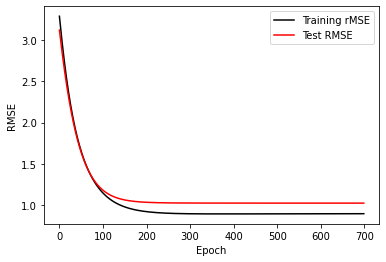

In [ ]:
#Tast 2-2
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(X,Y,c="black" , label = "Training rMSE")
plt.plot(X,Y_test, c="red", label="Test RMSE")
plt.legend()
plt.show()

## Task 3. User에게 추천하기


In [ ]:
#Task 3-1 
scores =[]
for num in set(rating_data.movieId):
  score = torch.dot(P[num] , Q[514]) + mean + bias_item[num] + bias_user[514]
  scores.append((round(score.item() , 5) , num , movie_dic[num]))
high_scores = sorted(scores , reverse= True)[:20]
print("예상별점 top 20")
listed_movie = pd.DataFrame(high_scores , columns = ['rating' , 'Id' , 'movie'])
listed_movie = listed_movie[["Id" , "movie"]]
listed_movie

예상별점 top 20


,Id,movie
0,318,"Shawshank Redemption, The (1994)"
1,2959,Fight Club (1999)
2,858,"Godfather, The (1972)"
3,296,Pulp Fiction (1994)
4,527,Schindler's List (1993)
5,356,Forrest Gump (1994)
6,50,"Usual Suspects, The (1995)"
7,260,Star Wars: Episode IV - A New Hope (1977)
8,1196,Star Wars: Episode V - The Empire Strikes Back...
9,1198,Raiders of the Lost Ark (Indiana Jones and the...


In [ ]:
#Task 3-2
high_ratings = rating_data[rating_data.rating == 5]
high_ratings = high_ratings[high_ratings.userId == 514]

meta  = pd.merge(movies , movie_tag , on = "movieId" , how = "inner")

In [ ]:
def jaccard_distance(set1 , set2):
  if len(set1 | set2) ==0: return 0
  return len(set1&set2) / len(set1 | set2)

def find_similar_movies(input_title , meta):
  if input_title not in meta.movieId:
    input_set = movies[movies.movieId == input_title].genres.item()
  else:
    input_meta = meta[meta.movieId == input_title]
    input_set = input_meta.genres.item() | input_meta.tag.item()

  result = []
  for this_title in meta.movieId:
    if this_title == input_title:
      continue
    if this_title not in meta.movieId:
      this_set = movies[movies.movieId == this_title].genres.item()
    else:
      this_meta = meta[meta.movieId == this_title]
      this_set = this_meta.genres.item() | this_meta.tag.item()

    jaccard = jaccard_distance(this_set , input_set)
    result.append((this_title , round(jaccard,3)))
  result.sort(key = lambda r : r[1] , reverse = True)
  return result[:5]
  
similar_movie = []  
for index in high_ratings.movieId:
  similar_movie.append((index , movie_dic[index] , find_similar_movies(index , meta)))

In [ ]:
#listed_movie = pd.DataFrame(high_scores , columns = ['rating' , 'Id' , 'movie'])
pd.DataFrame(similar_movie , columns = ['Id' , 'movie' , 'similar_movie'])
for id , movie , sim in similar_movie:
  print(f"{movie} 와 비슷한 영화들은 ")
  for i , r in sim:
    print(f"{i} - {movie_dic[i]} | score : {r}")
  print()

Star Wars: Episode IV - A New Hope (1977) 와 비슷한 영화들은 
1210 - Star Wars: Episode VI - Return of the Jedi (1983) | score : 0.286
1196 - Star Wars: Episode V - The Empire Strikes Back (1980) | score : 0.259
1200 - Aliens (1986) | score : 0.222
1240 - Terminator, The (1984) | score : 0.148
2628 - Star Wars: Episode I - The Phantom Menace (1999) | score : 0.143

Silence of the Lambs, The (1991) 와 비슷한 영화들은 
6323 - Identity (2003) | score : 0.3
4210 - Manhunter (1986) | score : 0.273
628 - Primal Fear (1996) | score : 0.267
22 - Copycat (1995) | score : 0.25
1994 - Poltergeist (1982) | score : 0.222

Star Wars: Episode V - The Empire Strikes Back (1980) 와 비슷한 영화들은 
1210 - Star Wars: Episode VI - Return of the Jedi (1983) | score : 0.267
260 - Star Wars: Episode IV - A New Hope (1977) | score : 0.259
1200 - Aliens (1986) | score : 0.25
2628 - Star Wars: Episode I - The Phantom Menace (1999) | score : 0.231
2640 - Superman (1978) | score : 0.231

Princess Bride, The (1987) 와 비슷한 영화들은 
6539 - Pi

## Task 4. 영화 클러스터링 하기

$||X_1 - X_2||^2_2 = X_1^T X_1 + X^T_2 X_2 - 2X_1^T X_2$

$ = 2(1-X_1^T X_2)$   이므로

만약 모든 vector를 unitvector로 만들어 준다면 코사인 유사도는 $X^T_1 X_2$ 가 될 것이다 따라서 아래와 같이 $Normalize$를 해준 후 유클리안 거리를 기본으로 제공하는 kmean 모듈을 사용하주면 코사인 유사도를 적용한 결과를 얻는다.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [ ]:
#Task 4-1
movie_once_data = rating_data.movieId.drop_duplicates()
movie_once_item = torch.LongTensor(movie_once_data) #item 번호
movie_once_p = P[movie_once_item] #그에 해당하는 영화벡터 

movie_once_user = rating_data.userId.drop_duplicates()
movie_once_user = torch.LongTensor(movie_once_user)
movie_once_q = Q[movie_once_user]

movie_once_p = movie_once_p.detach().numpy()
movie_once_q = movie_once_q.detach().numpy()

In [ ]:
#정규화 부분
X = (preprocessing.normalize(movie_once_p))

In [ ]:
all_cost = []
k_ = 40
for i in range(1, k_):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(X)
  all_cost.append(kmeans.inertia_)

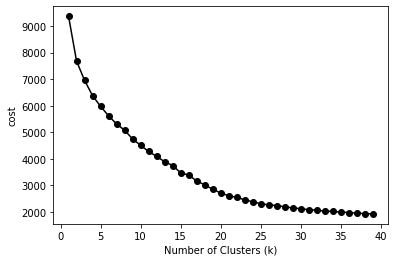

In [ ]:
#Task 4-2
num_clusters = list(range(1,k_))
plt.plot(num_clusters, all_cost, '-o' , color = 'black')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('cost')
plt.show()

In [ ]:
#Task4-3
kmeans = KMeans(n_clusters = 40 ,random_state = 0).fit(X)
ceneters , label = kmeans.cluster_centers_ , kmeans.labels_

In [ ]:
def cos_sim(a, b): return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

movie_index = list(movie_once_item).index(122912)
movie_knn = label[movie_index] #어느것으로 분류되었는지

cos_distance = []
movie_vec = movie_once_p[movie_index]
for index , k in enumerate(label):
  if k == movie_knn:
    movie_index = movie_once_item[index].item()
    cos_distance.append((round(cos_sim(movie_vec , movie_once_p[index]) ,3),movie_index , movie_dic[movie_index] ))

In [ ]:
cos_distance = sorted(cos_distance , reverse= True)[1:21]
pd.DataFrame(cos_distance , columns = ['score' , 'Id' , 'movie'])

,score,Id,movie
0,0.941,2648,Frankenstein (1931)
1,0.934,105653,Escape Plan (2013)
2,0.830,4980,Bill & Ted's Bogus Journey (1991)
3,0.810,107953,Dragon Ball Z: Battle of Gods (2013)
4,0.802,122922,Doctor Strange (2016)
5,0.799,55020,"Ten, The (2007)"
6,0.798,173145,War for the Planet of the Apes (2017)
7,0.796,356,Forrest Gump (1994)
8,0.794,122916,Thor: Ragnarok (2017)
9,0.793,167746,The Lego Batman Movie (2017)


## Task 5. 차원 축소화

In [ ]:
#Task5.1
p = P[movie_once_item] 
q = Q[movie_once_user]
Z = torch.concat((p,q))
Z = Z - torch.mean(Z)

In [ ]:
#Task5-2
U,S,V = torch.pca_lowrank(Z ,2)

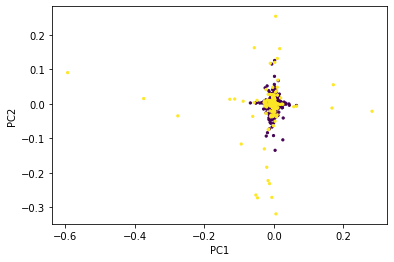

In [ ]:
#Task 5-3-1
p_c = [0 for _ in range(9724)]
q_c = [1 for _ in range(610)]
c = p_c + q_c
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(U[:,0].detach().numpy() , U[:,1].detach().numpy(), c = c,  s = 5)
plt.show()

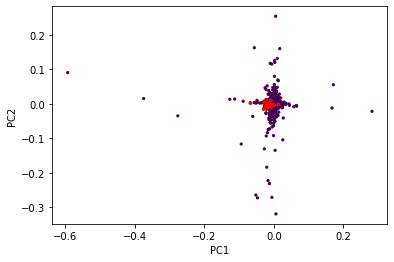

In [ ]:
#Task 5-3-2
c__ = []
u1 =[]
u2 = []
c = [0 for _ in range(10334)]
for i in listed_movie.Id:
  index = list(movie_once_item).index(i)
  c__.append("red")
  u1.append(U[index , 0].detach().numpy().item())
  u2.append(U[index , 1].detach().numpy().item())

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(U[:,0].detach().numpy() , U[:,1].detach().numpy(), c =c ,  s = 5)
plt.scatter(u1 , u2, c = c__, s = 7)
plt.show()

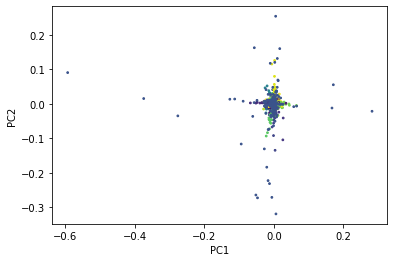

In [ ]:
#Task 5-3-3
c=  list(label) + [10 for _ in range(9724 , 10334)]
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(U[:,0].detach().numpy() , U[:,1].detach().numpy(), c = c ,  s = 3)
plt.show()

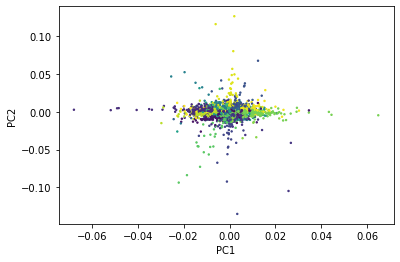

In [ ]:
#Task 5-3-3 - p벡터만
c=  list(label) 
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(U[:9724,0].detach().numpy() , U[:9724,1].detach().numpy(), c = c ,  s = 2)
plt.show()